This assigments assumes you've been (at least partly) through [Assignment 1](https://colab.research.google.com/drive/132p1bYleoq71Za1gz7_iP5nDnRPKWeFo) which contains information about the assignment submission process. Basically you need to make a copy of the Python notebook and register it in the [assignments spreadsheet](https://docs.google.com/spreadsheets/d/1PDU5qpydm2psfCTbCu47lYSPKETS9h__ZsVm9BgQFJ4), after ensuring that my email `karolos.potamianos@cern.ch` has access.

***Please don't forget to tell me who you are:***

**NAME:** Juan Carlos Suarez

**EMAIL:** juancarlos.suarez@selleco.com.co

In this tutorial, we'll use the [mobile health (MHEALTH) dataset](https://archive.ics.uci.edu/ml/datasets/MHEALTH+Dataset). 

The goal is to predict the activity that people are doing based on the measurements from 23 channels (device outputs).



In [ ]:
! [ ! -f MHEALTHDATASET.zip ] && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip || echo "Data already downloaded!"
! [ -d MHEALTHDATASET ] && echo "Data already extracted" || unzip MHEALTHDATASET.zip
! ls
! ls MHEALTHDATASET


# Let us get some information on the dataset

with open("MHEALTHDATASET/README.txt", encoding = "ISO-8859-1") as f:
  for l in f.readlines(): print(l)

Data already downloaded!
Data already extracted
CNN-Model.png  LSTM-Model.png  MHEALTHDATASET  MHEALTHDATASET.zip  sample_data
mHealth_subject10.log  mHealth_subject4.log  mHealth_subject8.log
mHealth_subject1.log   mHealth_subject5.log  mHealth_subject9.log
mHealth_subject2.log   mHealth_subject6.log  README.txt
mHealth_subject3.log   mHealth_subject7.log


*************************************************** mHealth dataset **********************************************************



Authors: Oresti Baños, Rafael Garcia, Alejandro Saez

Date: 22/10/2013

Institution: University of Granada (UGR) 

Department: Department of Computer Architecture and Computer Technology.

Contact: oresti@ugr.es (oresti.bl@gmail.com)



---------------------------------------------------------------------------------------------------------------------------------------------

NOTE: if you use this dataset please cite the following work



Banos, O., Garcia, R., Holgado-Terriza, J.A., Damas, M., Pomares,

Let us know have a look at the data output, to understand what we're dealing with. This image helps explain what we do: we make shorter sequences of 100 points (2s @ 50Hz) that we'll use to train.

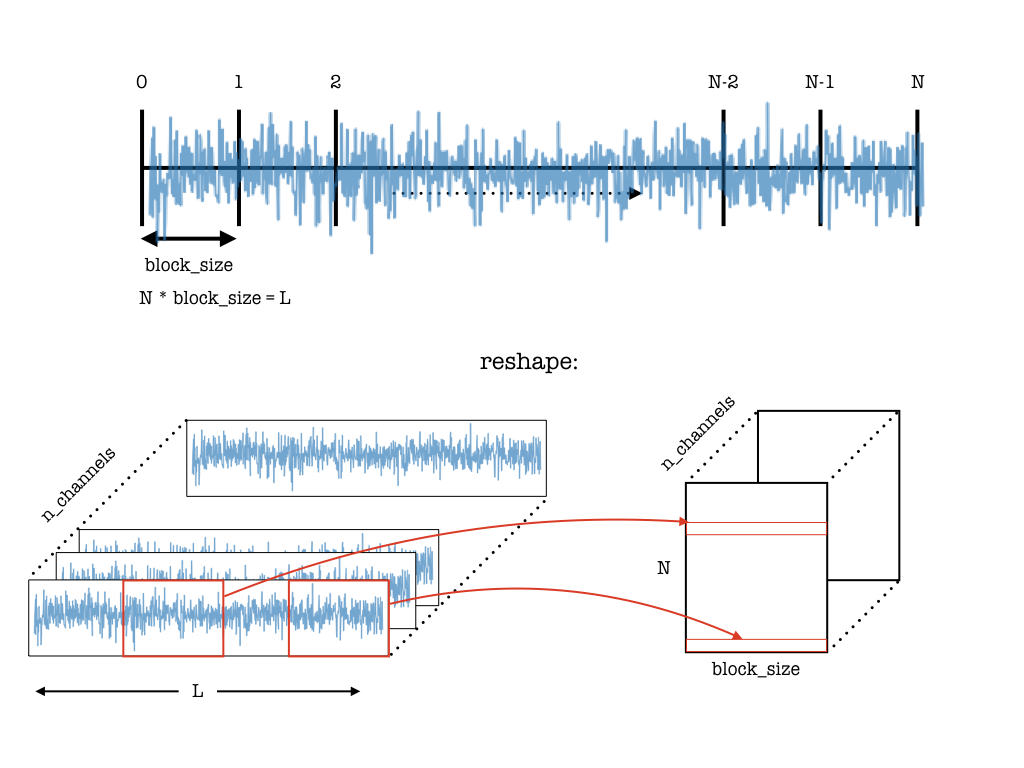


In [ ]:
import pandas as pd
import numpy as np

def read_subject(i):
  print(f"Processing file MHEALTHDATASET/mHealth_subject{i}.log")
  data = pd.read_csv(f"MHEALTHDATASET/mHealth_subject{i}.log", delimiter='\t',header=None)
  # Removing null class
  data = data[data[23]!=0]
  return data

# Let's make blocks of 100 points (i.e. 2s worth of points)
def split_in_blocks(data, block_size=100):
  X_ = []
  y_ = []

  groups = data.groupby(23)
  n_channels = data.shape[1]-1

  for gid in range(1,len(groups)+1):
    y = pd.unique(groups.get_group(gid)[23].to_numpy())
    x = groups.get_group(gid).drop(23, axis=1).to_numpy()
    n_blocks = len(x) // block_size

    x = x[:n_blocks*block_size]
    y = y[:n_blocks*block_size]

    x_tensor = x.reshape(-1, block_size, n_channels)

    # Append
    X_.append(x_tensor)
    y_.append(np.array([y]*len(x_tensor), dtype=int).squeeze())

  # Concatenate and return
  X = np.concatenate(X_, axis=0)
  y = np.concatenate(y_, axis=0)
  return X, y

block_size = 100
# Creating lists to save data
X_ = []
y_ = []
for s in range(1,11):
  data = read_subject(s)
  X, y = split_in_blocks(data, block_size)
  X_.append(X)
  y_.append(y)
# Concatenate
X = np.concatenate(X_, axis=0)
y = np.concatenate(y_, axis=0)

print(X.shape, y.shape)

# Code to bring everything in in one go
# data_list = []
# for i in range(1,11):
#   data = read_subject(i)
#   data_list.append( data )
# data = pd.concat(data_list, axis=0, ignore_index=True)
# print(data.head())
# # Checking the shape of our data
# print(data.shape)
# for i in range(1,13):
#   print(f"{i}: {data[data[23]==i].shape}")

Processing file MHEALTHDATASET/mHealth_subject1.log
Processing file MHEALTHDATASET/mHealth_subject2.log
Processing file MHEALTHDATASET/mHealth_subject3.log
Processing file MHEALTHDATASET/mHealth_subject4.log
Processing file MHEALTHDATASET/mHealth_subject5.log
Processing file MHEALTHDATASET/mHealth_subject6.log
Processing file MHEALTHDATASET/mHealth_subject7.log
Processing file MHEALTHDATASET/mHealth_subject8.log
Processing file MHEALTHDATASET/mHealth_subject9.log
Processing file MHEALTHDATASET/mHealth_subject10.log
(3355, 100, 23) (3355,)


Now that `X` represents the data from the 23 channels and the `y` the activity identifier (from 1 to 12), we can use the dataset.

We now need to split our data between the *training* and *testing* samples.
(We might even go further as we have a lot of data points.)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=123)

# Standardize
def standardise(X): return (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]

X_train = standardise(X_train)
X_test = standardise(X_test)

# Train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.4, stratify=y_train, random_state=456)

# One-hot encoding
def one_hot(labels, n_class): return np.eye(n_class)[:,labels-1].T

y_train = one_hot(y_train, n_class=12)
y_valid = one_hot(y_valid, n_class=12)
y_test = one_hot(y_test, n_class=12)

# Getting some numbers out
print("Training set size: ", len(X_train))
print("Validaton set size: ", len(X_valid))
print("Test set size: ", len(X_test))

Training set size:  1408
Validaton set size:  940
Test set size:  1007


Let us now train a network

(100, 23)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 256)               155648    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 12)                1548      
Total params: 190,092
Trainable params: 190,092
Non-trainable params: 0
_________________________________________________________________


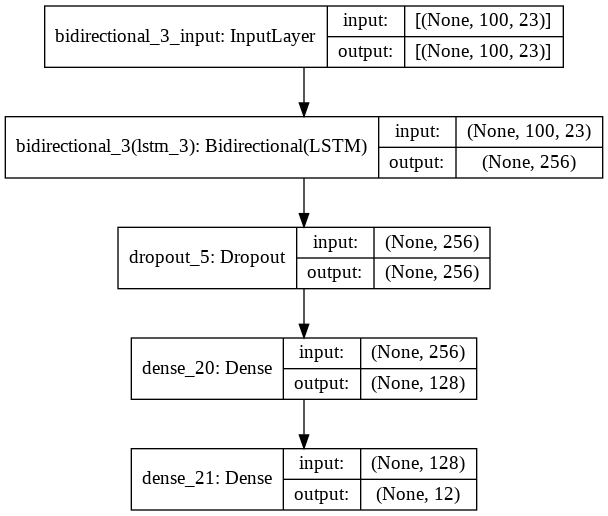

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

num_classes = 12
input_shape = (block_size, 23)
print(input_shape)
model = keras.Sequential(
    [ 
        keras.layers.Bidirectional(
          keras.layers.LSTM(
            units=128,
            input_shape=input_shape
          )
        ),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

model.build((None,100,23)) 
# Shows a nice summary of the model
model.summary()

!pip install pydot
from tensorflow.keras.utils import plot_model

plot_model(model, 'LSTM-Model.png', show_shapes=True)

Let's train our network.

In [ ]:
batch_size = 128
epochs = 20

# Feel free to change parameters below if needed
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
10/10 [==============================] - 3s 99ms/step - loss: 2.3594 - accuracy: 0.2064 - val_loss: 1.7772 - val_accuracy: 0.5745
Epoch 2/20
10/10 [==============================] - 0s 23ms/step - loss: 1.6059 - accuracy: 0.5661 - val_loss: 1.1534 - val_accuracy: 0.6596
Epoch 3/20
10/10 [==============================] - 0s 20ms/step - loss: 1.0121 - accuracy: 0.7255 - val_loss: 0.6956 - val_accuracy: 0.7801
Epoch 4/20
10/10 [==============================] - 0s 20ms/step - loss: 0.6099 - accuracy: 0.8169 - val_loss: 0.4673 - val_accuracy: 0.8440
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 0.3754 - accuracy: 0.8792 - val_loss: 0.2917 - val_accuracy: 0.9007
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 0.3224 - accuracy: 0.8984 - val_loss: 0.3020 - val_accuracy: 0.9291
Epoch 7/20
10/10 [==============================] - 0s 19ms/step - loss: 0.2851 - accuracy: 0.9004 - val_loss: 0.2198 - val_accuracy: 0.9433
Epoch 8/20
10

Let us plot the performance of our algorithm.

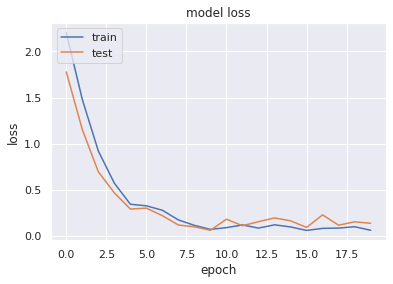

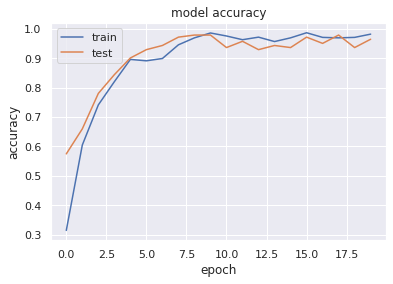

In [ ]:
def plot_history(history):
  import matplotlib.pyplot as plt
  %matplotlib inline

  for k in [ 'loss', 'accuracy']:
    # summarize history for accuracy
    plt.plot(history.history[f'{k}'])
    plt.plot(history.history[f'val_{k}'])
    plt.title(f'model {k}')
    plt.ylabel(f'{k}')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history)

1. Please provide some information on the performance of your model and a training.
**Answer:**<font color=”blue”>The performance this model achieved was of ~98% accuracy for the validation set and of ~99% accuracy for the training set. This is a very high performance which was almost already achieved after 7 epochs, which is a really fast convergence. I started working with a model that I found on the internet ([source](https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/13.time-series-human_activity_recognition.ipynb)) which was applied also for Human-activity-recognition. I was surprised that there was no need to adapt anything, like the hyperparameters or the number of Neurons in the LSTM layer. I decided to start by taking a model from the internet, and after that start testing models on my own (will be the next models). Also LSTM's are the NeuralNetwors to use in case of time series as it is the case of this classification task, then the IMU and ECG data were time series. Nevertheless after testing with other NeuralNetwork types (further below in the report), it became evident that it was not really necessary to use LSTM's. The fully connected layer before the output layer might help as a "summarizing" or "interpretation" layer from the outputs of the LSTM layer before passing it to the output to make a prediction.

Based on the Loss vs. epoch plot it is visible that the model performed as expected, then the loss started high but very rapidly decreased until converging close to zero. Both the validation and training losses behaved very similar.</font> <font color=”blue”>

Also when evaluating the Accuracy vs. epoch plot the same can be ovserved. Both the training vs the validation lines behave very similar.
</font><font color=”blue”>

As mentioned before, on both plots it is possible to see that the model almost already achieved its highest performance after 7 epochs.</font>

Obtaining the confusion matrix for the model.


32/32 [==============================] - 1s 6ms/step
Correcly classified 999 out of 1007 sequences (99.20556107249256%)


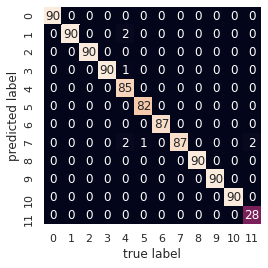

30/30 [==============================] - 0s 6ms/step
Correcly classified 933 out of 940 sequences (99.25531914893617%)


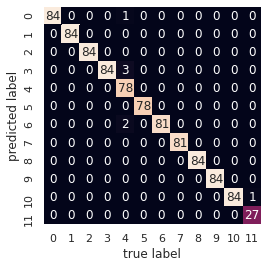

105/105 [==============================] - 1s 6ms/step
Correcly classified 3338 out of 3355 sequences (99.49329359165425%)


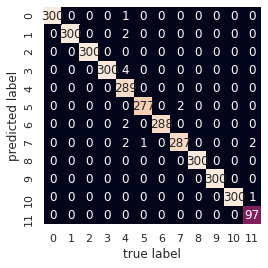

In [ ]:
def analyse_classifier(model, X, y):
  yPred = model.predict(X, verbose=1)
  from sklearn.metrics import confusion_matrix
  # Don't forget that in our model we have labels from 1 to 12
  cm = confusion_matrix(y.argmax(axis=1)+1, yPred.argmax(axis=1)+1)

  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns; sns.set()
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  nTotal = len(y)
  nCorrect = np.count_nonzero(y.argmax(axis=1)-yPred.argmax(axis=1)==0)
  print(f"Correcly classified {nCorrect} out of {nTotal} sequences ({nCorrect/nTotal*100}%)")

  plt.show()

analyse_classifier(model, X_test, y_test)
analyse_classifier(model, X_valid, y_valid)

# Running on the complete dataset
# We first need to standardise our input (which we didn't do before)
X_std = standardise(X)
# And we need to conver the full y into one-hot notation
analyse_classifier(model, X_std, one_hot(y, n_class=12))

## Training another classifier

1. Can you train another model ?

Feel free to split into multiple text/code blocks.


2. Can you try yet another ?

Try varying the parameters (copying to yet another cell ; don't forget to adjust the model variable to `model_3` or more).

In [ ]:
# Put your code here to train and evaluate another model (next cell)
from keras.layers import Conv1D, Dense, Dropout, Flatten

# Model definition
model_2 = keras.models.Sequential([
                                   Dense(12, activation='sigmoid', input_shape=input_shape),
                                   Flatten(),
                                   Dense(num_classes, activation='softmax')
])

# Shows a nice summary of the model
model_2.summary()

# Training
batch_size = 100
epochs = 50
model_2.compile(loss='kullback_leibler_divergence', optimizer="adam", metrics=["accuracy"])
history_2 = model_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100, 12)           288       
_________________________________________________________________
flatten_5 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 12)                14412     
Total params: 14,700
Trainable params: 14,700
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 1s 16ms/step - loss: 2.5436 - accuracy: 0.1196 - val_loss: 2.2326 - val_accuracy: 0.2057
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 2.0592 - accuracy: 0.3285 - val_loss: 1.9947 - val_accuracy: 0.3191
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 1.7958 - accuracy: 0.4120 -

Evaluation

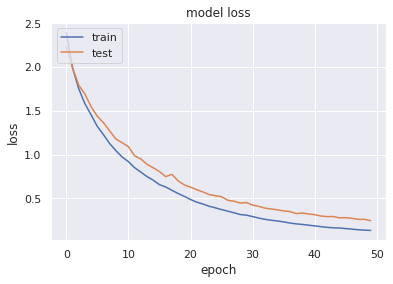

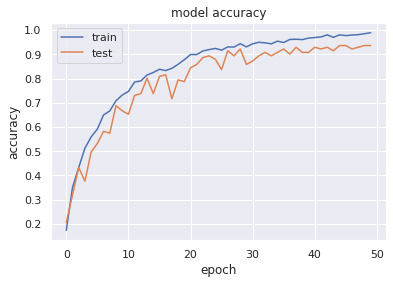

In [ ]:
plot_history(history_2)

32/32 [==============================] - 0s 2ms/step
Correcly classified 943 out of 1007 sequences (93.64448857994041%)


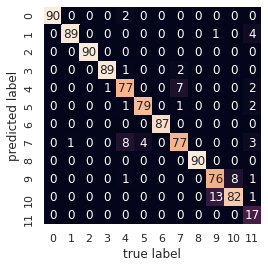

30/30 [==============================] - 0s 2ms/step
Correcly classified 876 out of 940 sequences (93.19148936170212%)


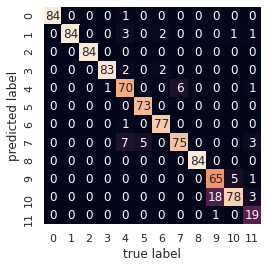

105/105 [==============================] - 0s 2ms/step
Correcly classified 3202 out of 3355 sequences (95.43964232488823%)


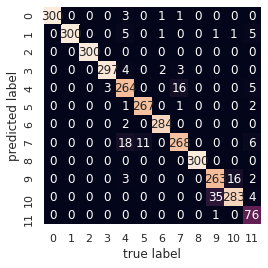

In [ ]:
analyse_classifier(model_2, X_test, y_test)
analyse_classifier(model_2, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model_2, X_std, one_hot(y, n_class=12))

### Yet another model

In [ ]:
# Put your code here to train and evaluate another model (next cell)
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPool1D

# Model definition
model_3 = keras.models.Sequential([
                                   Conv1D(12, kernel_size=2, activation='relu', input_shape=input_shape),
                                   Flatten(),
                                   Dense(num_classes, activation='softmax')
])

# Shows a nice summary of the model
model_3.summary()

# Training
batch_size = 100
epochs = 50
model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_3 = model_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 99, 12)            564       
_________________________________________________________________
flatten_7 (Flatten)          (None, 1188)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 12)                14268     
Total params: 14,832
Trainable params: 14,832
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
13/13 [==============================] - 1s 74ms/step - loss: 2.5220 - accuracy: 0.1634 - val_loss: 1.7990 - val_accuracy: 0.4397
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 1.5698 - accuracy: 0.4763 - val_loss: 1.4129 - val_accuracy: 0.5603
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 1.1885 - accuracy: 0.6176 

Evaluation

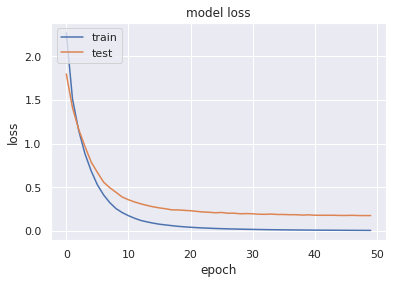

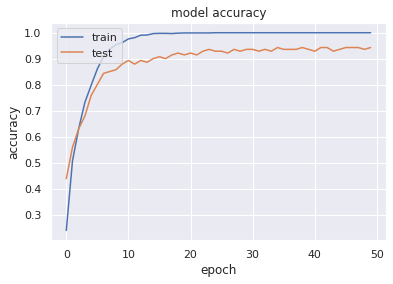

In [ ]:
plot_history(history_3)

32/32 [==============================] - 0s 1ms/step
Correcly classified 995 out of 1007 sequences (98.80834160873883%)


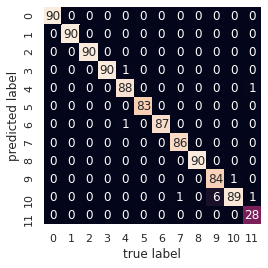

30/30 [==============================] - 0s 1ms/step
Correcly classified 927 out of 940 sequences (98.61702127659574%)


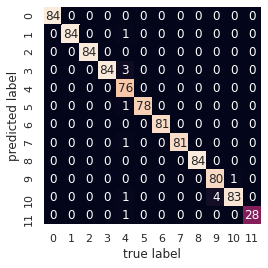

105/105 [==============================] - 0s 1ms/step
Correcly classified 3329 out of 3355 sequences (99.22503725782414%)


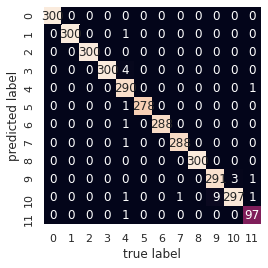

In [ ]:
analyse_classifier(model_3, X_test, y_test)
analyse_classifier(model_3, X_valid, y_valid)

# And we need to conver the full y into one-hot notation
analyse_classifier(model_3, X_std, one_hot(y, n_class=12))

**Personal analysis of trying different parameters:**

<font color=”blue”>I tested several combinations of hyperparameters using only *Fully Connected layer -> Flatten -> Output layer* and also *1D-Convolutiona layer -> Flatten -> Output layer.* I was surprised of the high performance of the models independent of the different parameters and simplicity of the models (basically consisting only of two layers). Here I want to present the observations I did by testing the different hyperparameters (I evaluated only changing small parameters and thats why I changed the same code the whole time so I don't have the code of all the combinations that I run):</font>
<font color=”blue”>
* I tested with two loss types, ```categorical_crossentropy``` and ```kullback_leibler_divergence``` on the FullyConnectedLayer model but did not notice any relevant difference when using each of them.</font>

<font color=”blue”> Different optimizers:
* When using ```SGD``` optimizer it converged slower than when using the ```ADAM``` optimizer. 
* When using ```RMSprop``` optimizer it converged as fast as ```ADAM``` optimizer, but its "trajectory" was more noisy/variable. It was seen on the loss vs. epochs plot as after some amount of epochs ```ADAM``` remained stable while ```RMSprop``` still had higher variations.
* When using ```ADADELTA``` the Network was not able to converge in 50 epochs and only achieved a ```val_acc``` of 10%.
* When using ```ADAGRAD``` the Network was also not able to converge in 50 epochs but it could be seen that is was going to converge and it achieved a ```val_acc``` of 63%.
* When using ```ADAMAX``` it behaved very similar to ```ADAM``` and ```RMSprop```.</font>

<font color=”blue”>Filters and Kernel-sizes in one ```Conv1D``` layer model:
* Using ```kernel_size=2``` and ```filters=3``` the model converged at a ```train_acc=93%``` while the ```val_acc``` remained at 73%. When changing to ```filters=6``` it converged at a ```train_acc=99%``` with ```val_acc=91%```.
* Using ```kernel_size=4``` and ```filters=3``` the model converged at a ```train_acc=85%``` and ```val_acc=68%```. When changing to ```filters=6``` it converged at a ```train_acc=100%``` with ```val_acc=90%```
* It seemed like a smaller ```kernel_size``` was better for this problem and also increasing the amount of filters increased the performance. The second makes sense as the filters in a convolutional layer can be interpreted as the extracted features, so the more features the better. 
Sigmoid vs. ReLU:
* I tested the ```Dense(units=12)``` once using the activation function ```ReLU``` and once the ```Sigmoid``` function. Using ```ReLU``` the ```train_acc``` converged to 100% with a ```val_acc``` of 91%. When ```Sigmoid``` was used the ```train_acc``` converged to 98% but with a ```val_acc``` of 94%. It seemed as if by using sigmoid function in this problem it was less prone to overfitting than ReLU. 
</font>

# Wrapping up

*Note: use this space for thoughts; this part is not part of the mark (unless you don't fill it at all).*

What did you take out from this?

**Answer:** <font color=”blue”>To wrap up I would like to say that I was impressed of the high performance that NeuralNetworks could achieve withouth giving it much thought. On one side they are very easy to use tools for several applications, but on the other side it is still unclear to me how to decide on the structure of a NeuralNetwork (for instance number of layers, number of nodes, activation functions, optimizers) for more complex problems when simple NeuralNetworks do not achieve a high performance. If a network would be performing poorly on a given task, I wouldn't know where to start modifying to improve the performance. Nevertheless I remain curious of understanding and applying NeuralNetworks more in order to feel more confident in their use. </font>